In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import os

from pyPSFstack.pupils.sources import DipoleInterfaceSource
from pyPSFstack.pupils.windows import SEO, Qplate
from pyPSFstack.pupils.aberrations import UnitaryAberrations
from pyPSFstack.core import PSFStack
from pyPSFstack.functions import trim_stack
from pyPSFstack.diversities.pola_diversities import PDiversity_QWP, \
    PDiversity_LP, PDiversity_Compound
from pyPSFstack.diversities.pupil_diversities import ZDiversity
from pyPSFstack.blurring import ExactBlurring

from pyPSFstack_torch.psf_modules import torchPSFStack
from pyPSFstack_torch.pupils.sources import torchDipoleInterfaceSource
from pyPSFstack_torch.pupils.windows import torchSEO
from pyPSFstack_torch.pupils.aberrations import torchUnitaryAberrations
from pyPSFstack_torch.diversities.pupil_diversities import torchZDiversity
from pyPSFstack_torch.diversities.pola_diversities import torchPDiversity_QWP, \
    torchPDiversity_LP, torchPDiversity_Compound
from pyPSFstack_torch.cost_functions import loss_loglikelihood, loss_sumsquared
from pyPSFstack_torch.functions import get_pupils_param_dict, get_normNbck, colorize

fig_folder='figures'
psf_cmap = 'inferno'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
fig_w = 16
plt.rcParams.update({"figure.facecolor" : "white"})

In [3]:
psf_cmap = 'inferno'

In [27]:
def plot_zpstack(stack, N_p=5, off_mid=0):
    v_max = np.max(stack)
    v_min = np.min(stack)

    N_z, _ = stack.shape[-2:]
    mid_ind = N_z//2 + off_mid
    
    fig, axs = plt.subplots(3,N_p,figsize=(fig_w,3*fig_w/N_p), gridspec_kw={'wspace':.05, 'hspace':0.05})
    for ind in range(N_p):
        im = axs[0,ind].imshow(stack[...,0,ind],vmin=v_min,vmax=v_max,cmap=psf_cmap)
        im = axs[1,ind].imshow(stack[...,mid_ind,ind],vmin=v_min,vmax=v_max,cmap=psf_cmap)
        im = axs[2,ind].imshow(stack[...,-1,ind],vmin=v_min,vmax=v_max,cmap=psf_cmap)
    for ax in axs.ravel():
        ax.set_axis_off()
    
    cb_ax = fig.add_axes([0.91,0.13,0.01,0.75])
    fig.colorbar(im, cax=cb_ax)

def plot_zstack(stack,N_z=5):
    v_max = np.max(stack)
    v_min = np.min(stack)

    n_z = stack.shape[-1]
    mid_ind = n_z//2
    in_ind = mid_ind - N_z//2
    fig, axs = plt.subplots(1,N_z,figsize=(fig_w,fig_w/N_z), gridspec_kw={'wspace':0.05, 'hspace':0})
    for ind in range(in_ind,in_ind+N_z):
        im = axs[ind-in_ind].imshow(stack[...,ind],vmin=v_min,vmax=v_max,cmap=psf_cmap)
    for ax in axs.ravel():
        ax.set_axis_off()  

    cb_ax = fig.add_axes([0.91,0.13,0.01,0.75])
    fig.colorbar(im, cax=cb_ax)

def plot_xyz(stack):
    v_max = np.max(np.reshape(stack,(4,-1)),axis=1).reshape(4,1,1,1)
    stack /= v_max
    fig, axs = plt.subplots(2,4, figsize=(2*fig_w/4,2*fig_w/8), gridspec_kw={'wspace':0.1, 'hspace':0})
    
    for ind in range(4):
        im = axs[0,ind].imshow(stack[ind][...,0],vmin=0,vmax=1,cmap=psf_cmap)
        axs[0,ind].set_axis_off()
        axs[1,ind].imshow(stack[ind][...,1],vmin=0,vmax=1,cmap=psf_cmap)
        axs[1,ind].set_axis_off()
    
    cb_ax = fig.add_axes([0.91,0.14,0.017,0.73])
    fig.colorbar(im, cax=cb_ax)

def plot_jones(jones):
    n_j = len(jones)
    fig, axs = plt.subplots(2, 2, figsize=(fig_w/4,fig_w/4), gridspec_kw={'wspace':-.05, 'hspace':0})
    axs = axs.ravel()
    for i in range(4):
        axs[i].imshow(colorize(jones[...,i%2,(i//2)%2]))
        axs[i].set_axis_off()

In [5]:
def get_xyzstack(pupil_sequence, pdiv):
    psf = PSFStack(pupil_sequence, pdiversity=pdiv)
    stack = []
    for dir in [[1,0,0],[0,1,0],[0,0,1],[0,0,0]]:
        psf.compute_psf_stack(orientation=dir)
        stack += [ trim_stack(psf.psf_stack,30)]
    return stack

In [8]:
def find_pupil(data_stack, params, lr=3e-2, n_epochs = 200, loss_fn=loss_loglikelihood, pdiv=True):

    tsrc = torchDipoleInterfaceSource(**params['pupil'],**params['source'])
    twdw = torchUnitaryAberrations(**params['pupil'], **params['aberrations'])
    tpupil_sequence = [tsrc, twdw]
    tzdiv = torchZDiversity(**params['zdiversity'], **params['pupil'])
    if pdiv:
        tpdiv = torchPDiversity_Compound([torchPDiversity_QWP(params['pdiversity']['qwp_angles']), 
            torchPDiversity_LP(params['pdiversity']['lp_angles'])])
    else:
        tpdiv=None

    model_retrieved = torchPSFStack(
                    data_stack.shape[0],
                    tpupil_sequence,
                    zdiversity=tzdiv,
                    pdiversity=tpdiv
                    )

    data_norm, data_bck = get_normNbck(data_stack)
    with torch.no_grad():
        model_retrieved.eval()
        first_est = model_retrieved()
    model_retrieved.set_scale_factor(data_norm/torch.sum(first_est))
    model_retrieved.set_pb_bck(data_bck, opt_b=True)
    with torch.no_grad():
        model_retrieved.eval()
        first_est = model_retrieved()


    optimizer = torch.optim.Adam(
        model_retrieved.parameters(), 
        lr=lr
    )
    data = torch.from_numpy(data_stack).type(torch.float)
    loss_evol =[]
    for epoch in tqdm(range(n_epochs)):
        
        model_retrieved.train()
        yhat = model_retrieved()
        
        loss = loss_fn(yhat, data)
        loss_evol += [loss.item()]
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()

    return model_retrieved, loss_evol

In [15]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# Numerical experiments for characterizing a birefringent window from a PSF stack

## 1. Parameter definition for the creation of simulated data

In [10]:
# Define number of points use for the computation 
N_pts = 128
# Experimental parameters
numerical_aperture = 1.49
magnification = 100
ni = 1.33
nf = 1.518
cam_pixel_size = 6500
radius = 10
wavelength = 525
dipole_orientation = [0,0,0] # this means incoherent
# Define positions of defocus
zi = -500; zf = 500; z_step = 100
z_list = np.arange(zi,zf+z_step,z_step)
# Define rotation angles of polarization analyzer
angle_i = 0; angle_f = np.pi/2; angle_step = np.pi/8
angle_list=np.arange(angle_i,angle_f,angle_step)

We put all the parameters in a dictionary 

In [11]:
params = {}
params['pupil'] = {}
params['pupil']['aperture_size'] = numerical_aperture / nf
params['pupil']['computation_size'] = wavelength*magnification/(cam_pixel_size*nf)
params['pupil']['N_pts'] = N_pts

params['source'] = {}
params['source']['ni'] = ni
params['source']['nf'] = nf
params['source']['delta'] = radius/wavelength

params['qplate'] = {}
params['qplate']['q'] = 1/2

params['seo'] = {}
params['seo']['c'] = 1.25*np.pi

params['zdiversity'] = {}
params['zdiversity']['z_list'] = z_list / wavelength
params['zdiversity']['nf'] = nf

params['pdiversity'] = {}
params['pdiversity']['qwp_angles'] = angle_list
params['pdiversity']['lp_angles'] = [0,np.pi/2]

params['blurring'] = {}
params['blurring']['ni'] = ni
params['blurring']['nf'] = nf
params['blurring']['radius'] = radius/wavelength
params['blurring']['diff_del_list'] = np.linspace(-radius/wavelength,
    radius/wavelength,8)[1:-1] 

params['aberrations'] = {}
params['aberrations']['jmax_list'] = [15]*4+[15]

Instantiate all the class elements need to define a PSF stack

In [12]:
# The source and window define th epupil sequence
src = DipoleInterfaceSource(**params['pupil'],**params['source'])
qplate = Qplate(**params['pupil'],**params['qplate'])
seo = SEO(**params['pupil'],**params['seo'])
# Then the diversities
zdiv = ZDiversity(**params['zdiversity'], **params['pupil'])
qwp = PDiversity_QWP(angle_list)
wollaston = PDiversity_LP([0, np.pi/2])
pdiv = PDiversity_Compound([qwp, wollaston])
blurring = ExactBlurring(**params['blurring'],**params['pupil'])

## 2. SEO

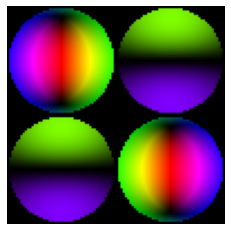

In [13]:
plot_jones(seo.get_pupil_array())
plt.savefig(os.path.join(fig_folder,'jones_seo.pdf'), bbox_inches='tight')

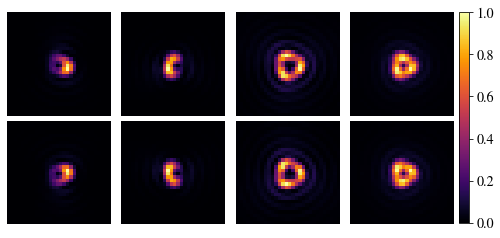

In [16]:
stack_xyz = get_xyzstack([src, seo], PDiversity_Compound([PDiversity_QWP([np.pi/4]), wollaston]))
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder,'seo_stackxyz.pdf'), bbox_inches='tight')

### 2.1 With polarization diversity

In [39]:
psfs = PSFStack([src, seo], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

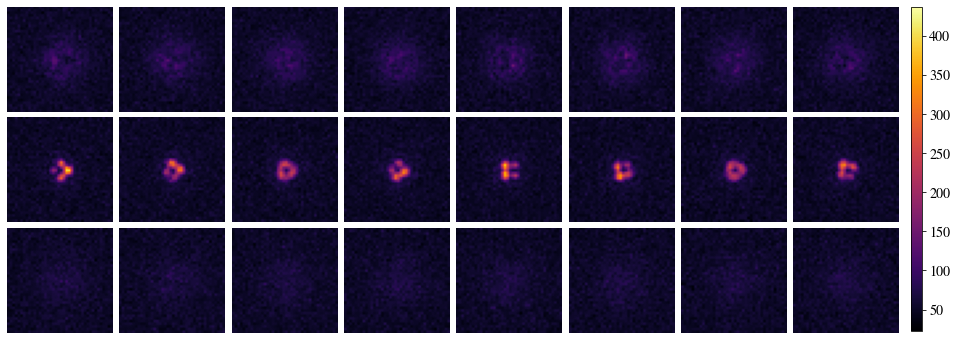

In [18]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=40,noise=True)
plot_zpstack(data_stack, N_p=8)
plt.savefig(os.path.join(fig_folder,'stack.pdf'), bbox_inches='tight')

/opt/anaconda3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272480871/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 200/200 [00:28<00:00,  7.05it/s]


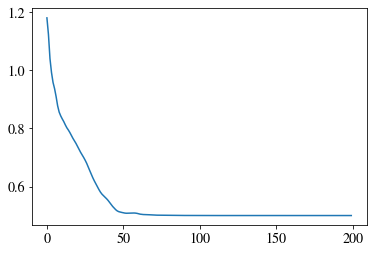

In [19]:
model, loss_evol = find_pupil(data_stack, params, lr=3e-2, n_epochs=200, loss_fn=loss_loglikelihood)
plt.plot(loss_evol)
# plt.gca().set_yscale('log')

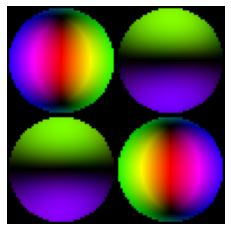

In [20]:
ret_pupil_params = get_pupils_param_dict(model)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil1'])
plot_jones(abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,'jones_seo_retzp.pdf'), bbox_inches='tight')

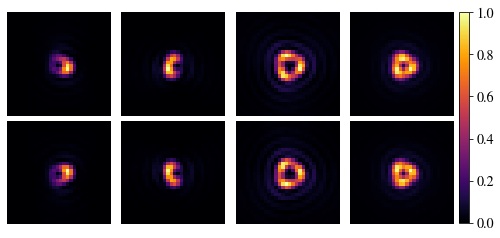

In [21]:
stack_xyz = get_xyzstack([src, abe], PDiversity_Compound([PDiversity_QWP([np.pi/4]), wollaston]))
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder,'seo_stackxyz_retzp.pdf'), bbox_inches='tight')

### 2.2 Without polarization diversity

In [43]:
psfs = PSFStack([src, seo], zdiversity=zdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

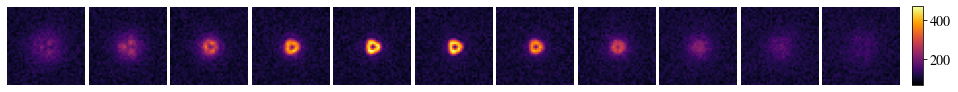

In [44]:
data_stack = psfs.model_experimental_stack(bckgd_photons=100,N_photons=20000,N_pts=40,noise=True)
plot_zstack(data_stack, N_z=11)

100%|██████████| 200/200 [00:14<00:00, 13.41it/s]


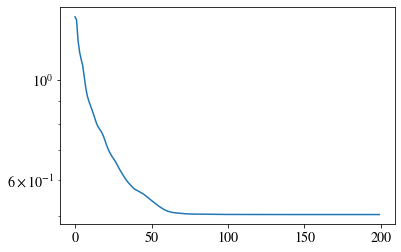

In [46]:
model, loss_evol = find_pupil(data_stack, params, lr=3e-2, n_epochs=200, loss_fn=loss_loglikelihood, pdiv=False)
plt.plot(loss_evol)
plt.gca().set_yscale('log')

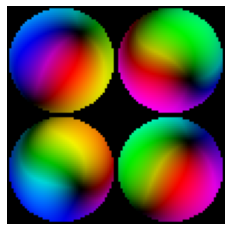

In [47]:
ret_pupil_params = get_pupils_param_dict(model)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil1'])
plot_jones(abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,'jones_seo_retz.pdf'), bbox_inches='tight')

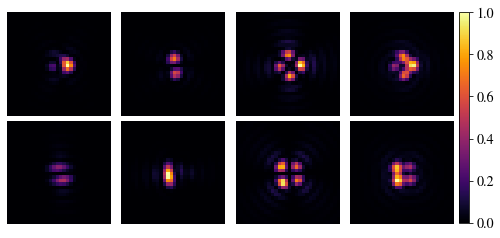

In [48]:
stack_xyz = get_xyzstack([src, abe], PDiversity_Compound([PDiversity_QWP([np.pi/4]), wollaston]))
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder,'seo_stackxyz_retz.pdf'), bbox_inches='tight')

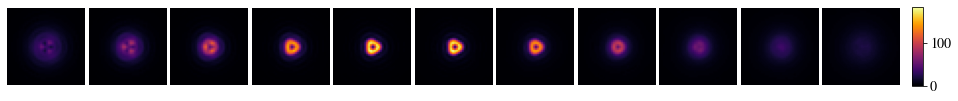

In [49]:
psfs_ret = PSFStack([src, abe], zdiversity=zdiv, blurring=blurring)
psfs_ret.compute_psf_stack(orientation=[0,0,0])
ret_stack = psfs_ret.model_experimental_stack(bckgd_photons=0,N_photons=10000,N_pts=40,noise=False)
plot_zstack(ret_stack, N_z=11)


## 3. Qplate

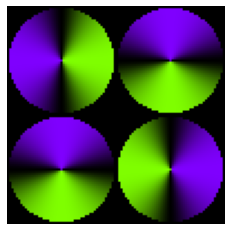

In [50]:
plot_jones(qplate.get_pupil_array())
plt.savefig(os.path.join(fig_folder,'jones_qp.pdf'), bbox_inches='tight')

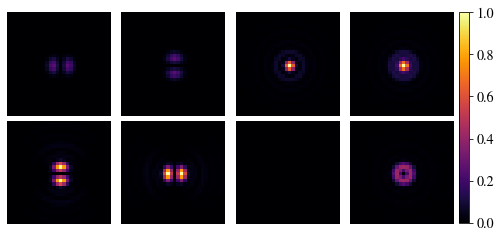

In [52]:
stack_xyz = get_xyzstack([src, qplate], wollaston)
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder,'qp_stackxyz.pdf'), bbox_inches='tight')

### 3.1 With polarization diversity

In [53]:
psfs = PSFStack([src, qplate], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

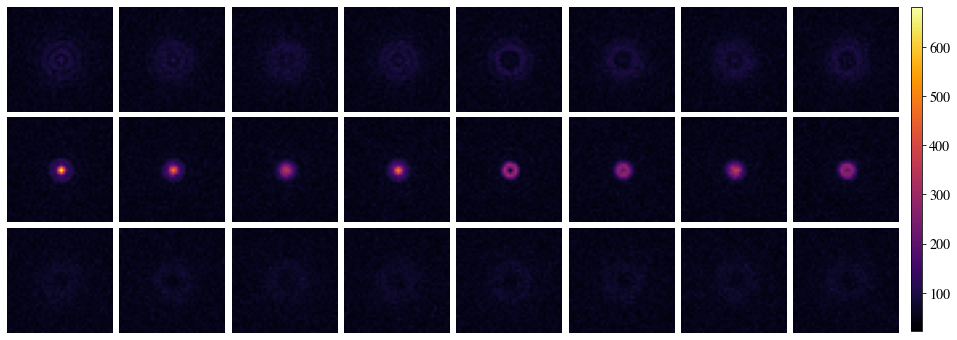

In [54]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=40,noise=True)
plot_zpstack(data_stack, N_p=8)

100%|██████████| 200/200 [00:28<00:00,  7.02it/s]


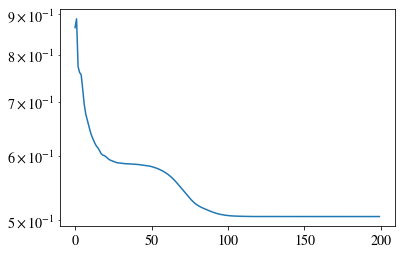

In [55]:
model, loss_evol = find_pupil(data_stack, params, lr=3e-2, n_epochs=200, loss_fn=loss_loglikelihood)
plt.plot(loss_evol)
plt.gca().set_yscale('log')

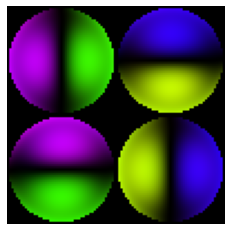

In [56]:
ret_pupil_params = get_pupils_param_dict(model)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil1'])
plot_jones(abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,'jones_qp_retzp.pdf'), bbox_inches='tight')

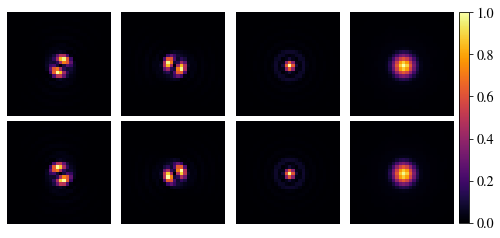

In [57]:
stack_xyz = get_xyzstack([src, abe], PDiversity_Compound([PDiversity_QWP([np.pi/4]), wollaston]))
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder,'qp_stackxyz_retzp.pdf'), bbox_inches='tight')

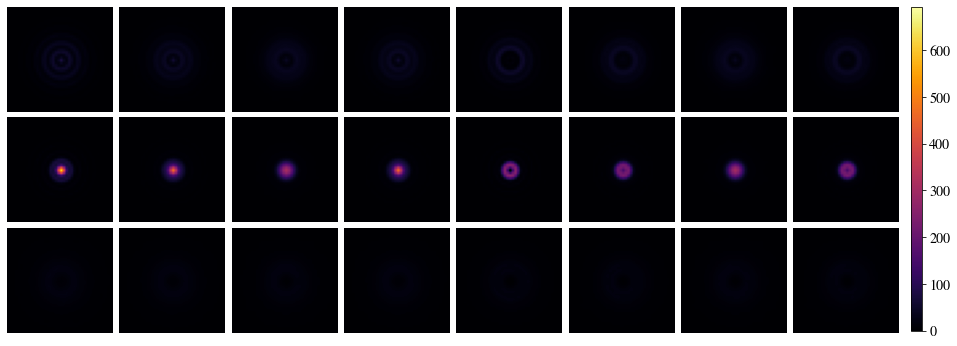

In [59]:
psfs_ret = PSFStack([src, abe], zdiversity=zdiv, pdiversity=pdiv)
psfs_ret.compute_psf_stack(orientation=[0,0,0])
ret_stack = psfs_ret.model_experimental_stack(bckgd_photons=0,N_photons=10000,N_pts=40,noise=False)
plot_zpstack(ret_stack, N_p=8)

In [16]:
from pyPSFstack.diversities.pola_diversities import jones_qwp, jones_hwp

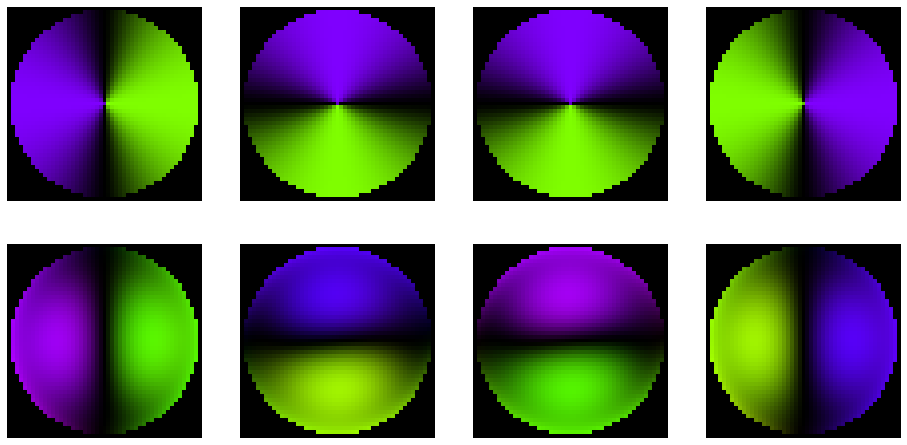

In [15]:
ret_pupil_params = get_pupils_param_dict(model)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil1'])
plot_jones([qplate.get_pupil_array(),abe.get_pupil_array()])

### 3.2 Without polarization diversity

In [13]:
psfs = PSFStack([src, qplate], zdiversity=zdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

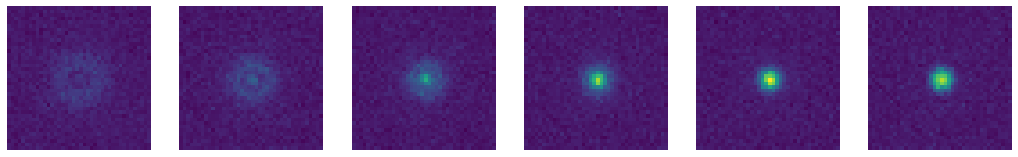

In [14]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=40,noise=True)
plot_zstack(data_stack)

c:\Users\Rodrigo.SAOPAULO\anaconda3\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 200/200 [00:12<00:00, 15.76it/s]


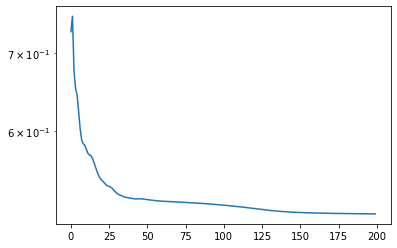

In [15]:
model, loss_evol = find_pupil(data_stack, params, lr=3e-2, n_epochs=200, loss_fn=loss_loglikelihood, pdiv=False)
plt.plot(loss_evol)
plt.gca().set_yscale('log')

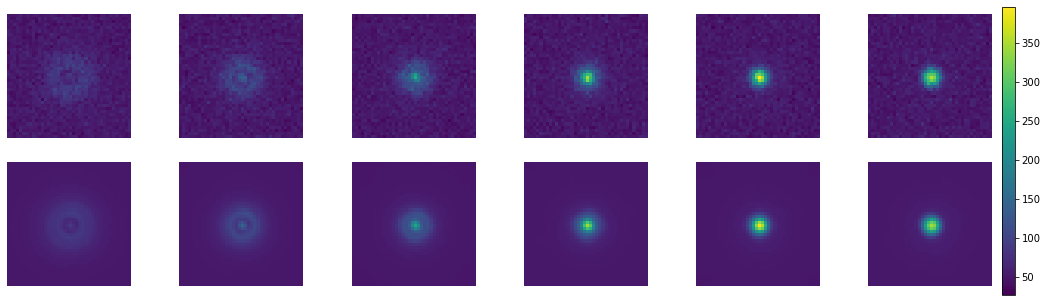

In [16]:
with torch.no_grad():
    model.eval()
    ret_stack = model()
plot_2zstacks(data_stack,ret_stack)


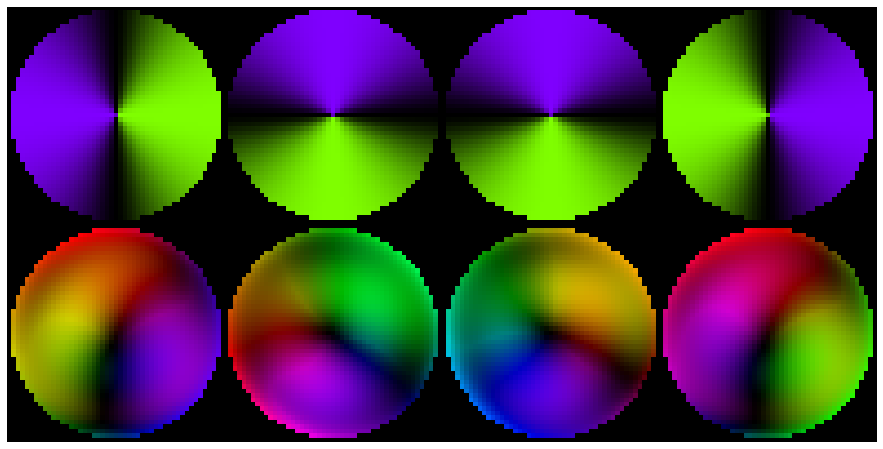

In [27]:
ret_pupil_params = get_pupils_param_dict(model)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil1'])
plot_jones([qplate.get_pupil_array(),abe.get_pupil_array()])

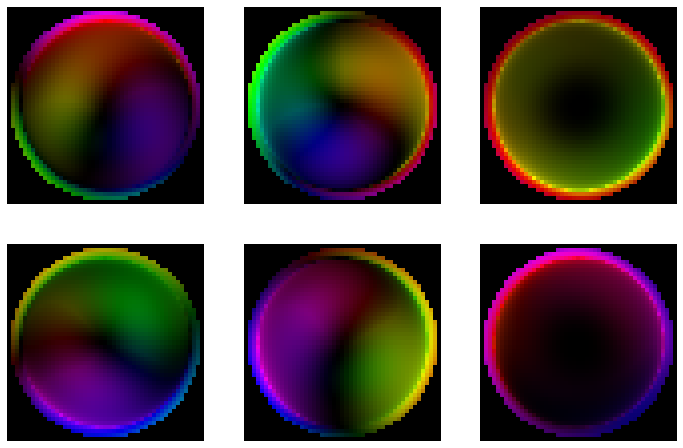

In [18]:
plot_compound_pupil([src.get_pupil_array(),abe.get_pupil_array()])

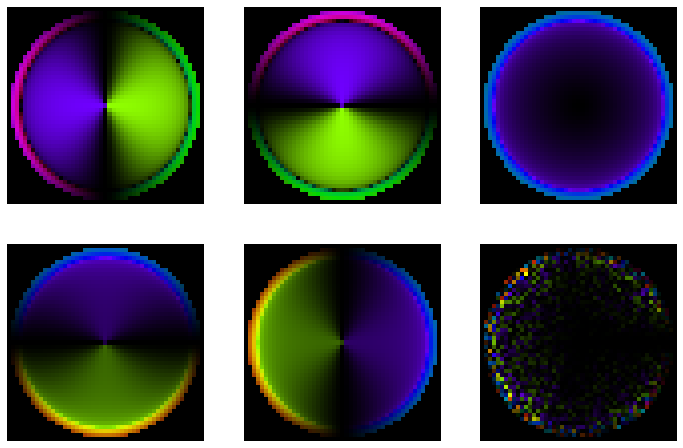

In [28]:
plot_compound_pupil([src.get_pupil_array(),qplate.get_pupil_array()])

In [39]:
dir_stack = get_xyzstack([src,qplate])
dir_stack_ret = get_xyzstack([src,abe])

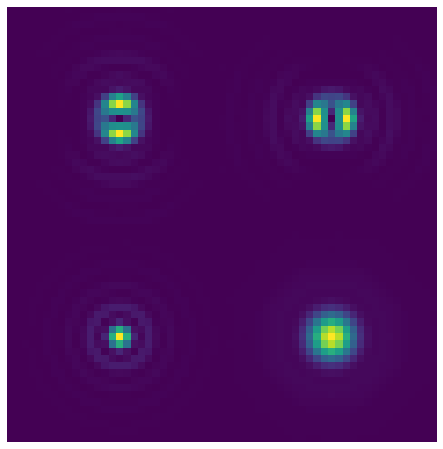

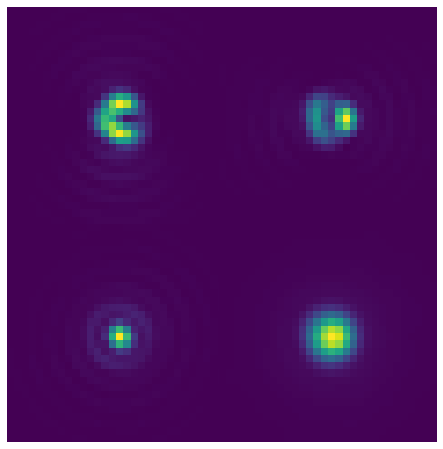

In [40]:
plot_xyz(dir_stack)
plot_xyz(dir_stack_ret)

# Extra stuff

In [ ]:
r,phi =src.polar_mesh()
plt.imshow(colorize(r*np.exp(1j*phi)*src.get_aperture(dummy_ind=0)))

In [ ]:
import scipy.io as sio
import sys
import os

In [ ]:
mat_data = sio.loadmat(os.path.join('data','Rodrigo_14Jul2021_TIRF_Run1.mat'))

In [ ]:
zdiv_mid_ind = 6
fig, axs = plt.subplots(3,3,figsize=(8,8))
for ind in range(3):
    axs[0,ind].imshow(mat_data['beads_rodrigo'][0,...,0,ind])
    axs[1,ind].imshow(mat_data['beads_rodrigo'][0,...,zdiv_mid_ind,ind])
    axs[2,ind].imshow(mat_data['beads_rodrigo'][0,...,-1,ind])
for ax in axs.ravel():
    ax.set_axis_off()

In [ ]:
exp_stack = 0.24*(mat_data['beads_rodrigo'][0]-100)

In [ ]:
get_normNbck(exp_stack)